## Assignment 3

In this task we implement a simple single hidden layer neural networks with logistic regression classifier on CIFAR10 dataset. Our implementation consists of 2 main class:

    MLP

    Contains implementation of multilayer perceptron. NUmber of hidden layers specified by user. 

    ModelEvaluator

    Class consisting of basic functionalities for training, testing and visualizing loss. 
    Additionally, implements Hinge Loss and Softmax loss without torch.nn.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle as skshuffle
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from matplotlib import pyplot as plt



In [4]:
class MLP(torch.nn.Module):
    def __init__(self, n_in, n_hidden, drop_p, n_out, act):
        super(MLP, self).__init__()
        '''
        n_in: Number of Inputs
        n_hidden: List with units in hidden layers
        n_out: Number of Output Units
        '''
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.p = drop_p
        self.input_layer = nn.Linear(self.n_in, self.n_hidden[0])
        if act =='relu':
            self.nonlin = nn.ReLU()
        elif act =='tanh':
            self.nonlin = nn.Tanh()
        elif act=='sigmoid':
            self.nonlin = nn.Sigmoid()
        self.hidden = nn.ModuleList()

        for i in range(len(self.n_hidden)-1):
            self.hidden.append(nn.Linear(self.n_hidden[i], self.n_hidden[i+1]))
            self.hidden.append(self.nonlin) 
            self.hidden.append(nn.Dropout(p = self.p))
        self.final_fc = nn.Linear(self.n_hidden[-1], self.n_out)


    def forward(self, X):
        '''
        forward pass
        '''
        X = self.nonlin(self.input_layer(X))
        for layer in self.hidden:
            X = layer(X)
        return X

Basic functionalities for evaluating model alongwith implementation of hinge and softmax loss.

In [5]:
class ModelEvaluator:
    def __init__(self, model, epochs, lr, loss_type='softmax', l2=0.0, use_gpu=False, optim='adam'):
        '''
        model: instance of pytorch model class
        epochs: number of training epochs
        lr: learning rate
        use_gpu: to use gpu
        optim: optimizer used for training, SGD or adam
        '''
        self.epochs = epochs
        self.lr = lr
        self.model = model
        self.loss_type = loss_type
        self.l2 = l2
        self.use_gpu = use_gpu
        self.train_loss = []
        self.test_loss = []

        if self.use_gpu:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

            if self.device == 'cuda:0':
                if torch.cuda.device_count()>1:
                    self.model = nn.DataParallel(model)
                self.model.to(device)

        if optim=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optim=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr = lr, momentum=0.9)
        elif optim=='adadelta':
            self.optimizer = torch.optim.Adadelta(self.model.parameters(), lr = lr, eps=1e-6, weight_decay=0)
        elif optim=='adagrad':
            self.optimizer = torch.optim.Adagrad(self.model.parameters(), lr = lr, lr_decay=1e-6, weight_decay=0)
        elif optim=='rmsprop':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr = lr, alpha=0.995, eps=1e-7, weight_decay=0)
        else:
            ValueError('Optimizer Not Supported')

    def softmax_loss(self, scores, y_label):
        '''
        softmax loss without torch.nn
        '''
        exp_scores = torch.exp(scores - torch.max(scores, dim=1)[0].view(-1,1))
        sum_exp_scores = exp_scores.sum(dim=1).view(-1,1)
        softmax_prob = exp_scores/sum_exp_scores
        loss = -torch.log(softmax_prob[np.arange(len(scores)), y_label])
        loss = loss.sum()
        return loss

    def hinge_loss(self, scores, y_label):
        '''
        hinge loss for multiclass without torch.nn
        '''
        hinge_loss = torch.clamp(scores - scores[np.arange(len(scores)),y_label].view(-1,1) + 1, min=0)
        hinge_loss[np.arange(len(scores)),y_label] = 0
        hinge_loss = hinge_loss.sum()

        return hinge_loss

    def l2_regularization(self, loss, lam):
        l2 = 0
        for W in self.model.parameters():
            l2 += W.norm(2)
        loss = model.loss() + 0.5*lam*l2
        return loss	


    def train(self, epoch, trainloader, print_every=100):
        '''
        method for training
        '''
        loss_batch = 0
        for b_idx, (train_data, train_labels) in enumerate(trainloader):
            if self.use_gpu and self.device == 'cuda:0':
                train_data, train_labels = train_data.to(self.device), train_labels.to(self.device)
            train_data = train_data.reshape(-1, 32*32*3)

            # Scale Images
            train_data = train_data / 255

            # Forward Pass 
            train_preds = self.model.forward(train_data)

            if self.loss_type=='softmax':
                loss = self.softmax_loss(train_preds, train_labels)
            elif self.loss_type =='hinge':
                loss = self.hinge_loss(train_preds, train_labels)
            else:
                ValueError('Loss Not Supported')
            if self.l2:
                loss = l2_regularization(loss, lam)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if b_idx%print_every == 0:
                print('Train Epoch: {0} [{1}/{2} ({3:.0f}%)]\t Loss {4:.6f}'.
                    format(epoch, b_idx*len(train_data), len(trainloader.dataset), 
                        100.*b_idx/len(trainloader), loss))

            loss_batch += loss
        loss_batch /= len(trainloader)
        self.train_loss.append(loss_batch)    

    def validation(self, valloader):
        '''
        method for testing
        '''
        correct_, total_ = 0, 0
        with torch.no_grad():
            loss = 0
            for val_data, val_labels in valloader:
                if self.use_gpu and self.device == 'cuda:0':
                    val_data, val_labels = test_data.to(self.device), val_labels.to(self.device)
                val_data = val_data.reshape(-1, 32*32*3)
                val_data = val_data / 255
                val_preds = self.model.forward(val_data)

                if self.loss_type=='softmax':
                    loss += self.softmax_loss(val_preds, val_labels)
                elif self.loss_type =='hinge':
                    loss += self.hinge_loss(val_preds, val_labels)
                else:
                    ValueError('Loss Not Supported')

                _, val_pred_labels = torch.max(val_preds.data, 1)
                total_ += val_labels.size(0)
                correct_ += (val_pred_labels.cpu() == val_labels.cpu()).sum()

            loss /= len(valloader)
            self.val_loss.append(loss)
            accuracy_val = (100.0*correct_/total_)
            print('Validation Loss {1:.2f} Accuracy on validation set {2:.2f}'.format(loss, accuracy_val))
            return accuracy_val

    def test(self, testloader):
        '''
        method for testing
        '''
        correct_, total_ = 0, 0
        with torch.no_grad():
            loss = 0
            for test_data, test_labels in testloader:
                if self.use_gpu and self.device == 'cuda:0':
                    test_data, test_labels = test_data.to(self.device), test_labels.to(self.device)
                test_data = test_data.reshape(-1, 32*32*3)
                test_data = test_data / 255
                test_preds = self.model.forward(test_data)

                if self.loss_type=='softmax':
                    loss += self.softmax_loss(test_preds, test_labels)
                elif self.loss_type =='hinge':
                    loss += self.hinge_loss(test_preds, test_labels)
                else:
                    ValueError('Loss Not Supported')

                _, test_pred_labels = torch.max(test_preds.data, 1)
                total_ += test_labels.size(0)
                correct_ += (test_pred_labels.cpu() == test_labels.cpu()).sum()

            loss /= len(testloader)
            self.test_loss.append(loss)
            accuracy_test = (100*correct_/total_)
            print('Accuracy of model on test set {0:.2f}'.format(accuracy_test))
            return accuracy_test

    def evaluator(self, trainloader, testloader, print_every=1000, validation=False):
        for epoch in range(self.epochs):
            self.train(epoch, trainloader, print_every=print_every)
            if validation:
                acc_ = self.validation(testloader)
            else:
                acc_ = self.test(testloader)
        return acc_
    def plot_loss(self, validation=False):
        '''
        to visualize loss
        '''
        plt.plot(range(len(self.train_loss)), self.train_loss, label='Training Loss')
        if validation:
            plt.plot(range(len(self.val_loss)), self.val_loss, label='Validation Loss')
        else:
            plt.plot(range(len(self.test_loss)), self.test_loss, label='Testing Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()

In [6]:
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Parameters
n_in = np.prod(trainset[0][0].numpy().shape)
n_out = len(classes)
batch_size = 100

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Hyperparameters
lr = 0.001
n_hidden = 512
epochs = 30
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

## Softmax Loss

In [8]:
# Model
n_hidden = [512, 256, 128]
l2 = 0.0
drop_p = 0.3
loss_type = 'softmax'
model = MLP(n_in, n_hidden, drop_p, n_out)
modeleval = ModelEvaluator(model, epochs, lr, loss_type=loss_type, l2=l2, use_gpu=True)
modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)

Train Epoch: 0 [0/50000 (0%)]	 Loss 485.452820
Train Epoch: 0 [10000/50000 (20%)]	 Loss 373.308441
Train Epoch: 0 [20000/50000 (40%)]	 Loss 385.771271
Train Epoch: 0 [30000/50000 (60%)]	 Loss 357.116730
Train Epoch: 0 [40000/50000 (80%)]	 Loss 348.463440
Accuracy of model on test set 18.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 369.592621
Train Epoch: 1 [10000/50000 (20%)]	 Loss 357.686401
Train Epoch: 1 [20000/50000 (40%)]	 Loss 340.391846
Train Epoch: 1 [30000/50000 (60%)]	 Loss 343.185516
Train Epoch: 1 [40000/50000 (80%)]	 Loss 318.241882
Accuracy of model on test set 24.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 368.164307
Train Epoch: 2 [10000/50000 (20%)]	 Loss 325.187164
Train Epoch: 2 [20000/50000 (40%)]	 Loss 345.665985
Train Epoch: 2 [30000/50000 (60%)]	 Loss 336.853424
Train Epoch: 2 [40000/50000 (80%)]	 Loss 358.013458
Accuracy of model on test set 26.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 336.330780
Train Epoch: 3 [10000/50000 (20%)]	 Loss 355.842712
Train Epoch: 3 [20000/50000 

Accuracy of model on test set 36.00
Train Epoch: 28 [0/50000 (0%)]	 Loss 274.751434
Train Epoch: 28 [10000/50000 (20%)]	 Loss 333.888519
Train Epoch: 28 [20000/50000 (40%)]	 Loss 304.672058
Train Epoch: 28 [30000/50000 (60%)]	 Loss 322.105316
Train Epoch: 28 [40000/50000 (80%)]	 Loss 317.140472
Accuracy of model on test set 36.00
Train Epoch: 29 [0/50000 (0%)]	 Loss 311.733398
Train Epoch: 29 [10000/50000 (20%)]	 Loss 365.297394
Train Epoch: 29 [20000/50000 (40%)]	 Loss 271.802612
Train Epoch: 29 [30000/50000 (60%)]	 Loss 330.006104
Train Epoch: 29 [40000/50000 (80%)]	 Loss 272.941010
Accuracy of model on test set 36.00


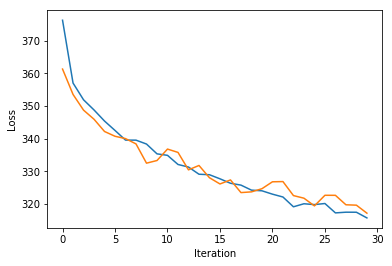

In [9]:
modeleval.plot_loss()

## Hinge Loss

In [13]:
# Model
n_hidden = [512, 256, 128]
l2 = 0.0
drop_p = 0.3
loss_type = 'hinge'
model = MLP(n_in, n_hidden, drop_p, n_out)
modeleval = ModelEvaluator(model, epochs, lr, loss_type=loss_type, l2=l2, use_gpu=True)
modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)

Train Epoch: 0 [0/50000 (0%)]	 Loss 12674.858398
Train Epoch: 0 [10000/50000 (20%)]	 Loss 6078.514648
Train Epoch: 0 [20000/50000 (40%)]	 Loss 4886.843262
Train Epoch: 0 [30000/50000 (60%)]	 Loss 4371.141113
Train Epoch: 0 [40000/50000 (80%)]	 Loss 4731.263672
Accuracy of model on test set 14.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 4765.041992
Train Epoch: 1 [10000/50000 (20%)]	 Loss 4701.967773
Train Epoch: 1 [20000/50000 (40%)]	 Loss 4686.915527
Train Epoch: 1 [30000/50000 (60%)]	 Loss 4720.415527
Train Epoch: 1 [40000/50000 (80%)]	 Loss 3927.243408
Accuracy of model on test set 18.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 3992.971436
Train Epoch: 2 [10000/50000 (20%)]	 Loss 4598.906250
Train Epoch: 2 [20000/50000 (40%)]	 Loss 4329.773926
Train Epoch: 2 [30000/50000 (60%)]	 Loss 3868.677734
Train Epoch: 2 [40000/50000 (80%)]	 Loss 3981.881592
Accuracy of model on test set 21.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 4665.524902
Train Epoch: 3 [10000/50000 (20%)]	 Loss 4463.623535
Train Epoc

Train Epoch: 27 [30000/50000 (60%)]	 Loss 3904.100098
Train Epoch: 27 [40000/50000 (80%)]	 Loss 4538.813965
Accuracy of model on test set 36.00
Train Epoch: 28 [0/50000 (0%)]	 Loss 3021.942871
Train Epoch: 28 [10000/50000 (20%)]	 Loss 5392.777832
Train Epoch: 28 [20000/50000 (40%)]	 Loss 4385.253906
Train Epoch: 28 [30000/50000 (60%)]	 Loss 4644.941895
Train Epoch: 28 [40000/50000 (80%)]	 Loss 5089.250488
Accuracy of model on test set 36.00
Train Epoch: 29 [0/50000 (0%)]	 Loss 3947.464600
Train Epoch: 29 [10000/50000 (20%)]	 Loss 3997.552979
Train Epoch: 29 [20000/50000 (40%)]	 Loss 4638.043945
Train Epoch: 29 [30000/50000 (60%)]	 Loss 4138.790527
Train Epoch: 29 [40000/50000 (80%)]	 Loss 3981.148682
Accuracy of model on test set 36.00


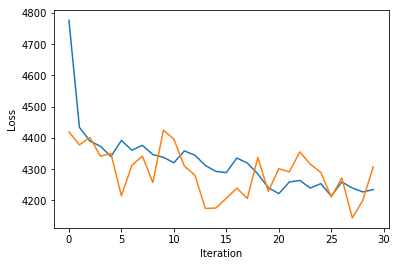

In [14]:
modeleval.plot_loss()

In [ ]:
# Model
n_hidden = [512, 256, 128]
l2 = 0
drop_p = 0.3
loss_type_ = ['softmax', 'hinge']
optim_ = ['sgd', 'rmsprop', 'adam', 'adagrad', 'adadelta']
non_lin_ = ['tanh','relu', 'sigmoid']

for l_t in loss_type_:
    for opt in optim_:
        for nlin in non_lin_:
            model = MLP(n_in, n_hidden, drop_p, n_out, nlin)
            modeleval = ModelEvaluator(model, epochs, lr, loss_type=l_t, l2=l2, use_gpu=True, optim=opt)
            acc_ = modeleval.evaluator(trainloader, testloader, print_every=100, validation=False)
            modelname = 'model_loss_{}_optimizer{}_nonlin_{}'.format(l_t, opt, nlin)
            print('Accuracy of {0} is {1:.2f}'.format(modelname, acc_))
            torch.save(modeleval.model.state_dict(), modelname)
            plt = modeleval.plot_loss()
            plt.savefig('train_test_loss_losstype: {0}, optim{1}, non_lin{2}'.format())
            plt.show()

Train Epoch: 0 [0/50000 (0%)]	 Loss 483.434937
Train Epoch: 0 [10000/50000 (20%)]	 Loss 343.070465
Train Epoch: 0 [20000/50000 (40%)]	 Loss 343.476562
Train Epoch: 0 [30000/50000 (60%)]	 Loss 346.431183
Train Epoch: 0 [40000/50000 (80%)]	 Loss 340.990753
Accuracy of model on test set 9.00
Train Epoch: 1 [0/50000 (0%)]	 Loss 342.678925
Train Epoch: 1 [10000/50000 (20%)]	 Loss 351.759521
Train Epoch: 1 [20000/50000 (40%)]	 Loss 362.831024
Train Epoch: 1 [30000/50000 (60%)]	 Loss 343.526123
Train Epoch: 1 [40000/50000 (80%)]	 Loss 345.113922
Accuracy of model on test set 9.00
Train Epoch: 2 [0/50000 (0%)]	 Loss 347.456604
Train Epoch: 2 [10000/50000 (20%)]	 Loss 339.988831
Train Epoch: 2 [20000/50000 (40%)]	 Loss 359.540222
Train Epoch: 2 [30000/50000 (60%)]	 Loss 348.270416
Train Epoch: 2 [40000/50000 (80%)]	 Loss 354.577545
Accuracy of model on test set 10.00
Train Epoch: 3 [0/50000 (0%)]	 Loss 340.275330
Train Epoch: 3 [10000/50000 (20%)]	 Loss 348.450897
Train Epoch: 3 [20000/50000 (4